In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

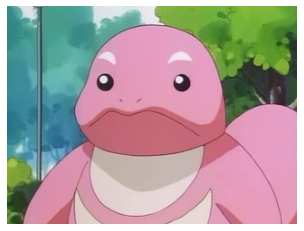

In [6]:
# load the image and convert it to a floating point data type
img_path = "./excelangue.jpg"
image = img_as_float(io.imread(img_path))
plt.imshow(image)
plt.axis('off')
plt.show()

### Apply SLIC Segmentation

In [7]:
n_segments = 200
compactness = 40
max_iter = 1

In [8]:
labels = slic(image=image, 
              n_segments=n_segments, 
              compactness=compactness)

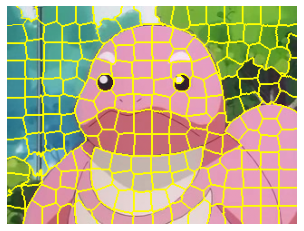

In [9]:
plt.imshow(mark_boundaries(image, labels))
plt.axis('off')
plt.show()

### Fixed Palette Colors

In [12]:
# init palette with mean color
n_colors = 5
palette = np.zeros((n_colors, 3))
prob_palette = np.zeros(n_colors)

palette[0] = np.mean(image.reshape(-1, 3), axis=0)
prob_palette[0] = 1

In [13]:
def get_prob_by_superpixel(image, labels, palette, prob_palette, T):
    # Get list of unique labels matching each superpixel
    unique_labels = np.unique(labels)
    n_superpixels = len(unique_labels)
    
    # Initialize empty array for p(color|superpixel)
    cond_prob = np.zeros((n_superpixels, palette.shape[0]))
    
    # Iterate over superpixels
    for i, label in enumerate(unique_labels):
        # Compute superpixel mean color
        superpixel_idx = np.where(labels == label)
        mean_color = np.mean(image[superpixel_idx], axis=0)
        
        # Compute energy term of conditional probability of each color
        cond_prob[i] = np.exp(- np.linalg.norm(palette - mean_color, axis=-1) / T)
    
    # Multiply by color likelihood and normalize
    cond_prob = prob_palette * cond_prob
    cond_prob = cond_prob / np.sum(cond_prob, axis=-1)[:, None]
    return cond_prob

In [14]:
cond_prob = get_prob_by_superpixel(image, labels, palette, prob_palette, 1)

### Hierarchical clustering of colors

In [15]:
import hdbscan

In [68]:
clstr_hdbscan = hdbscan.HDBSCAN(min_cluster_size=15, 
                                gen_min_span_tree=True)

In [69]:
img_colors = image.reshape(-1, 3)
clstr_hdbscan.fit(img_colors)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=15, min_samples=None, p=None,
        prediction_data=False)

In [75]:
import pandas as pd

In [76]:
tree = clstr_hdbscan.condensed_tree_.to_pandas()

In [77]:
tree

,parent,child,lambda_val,child_size
0,76800,165,8.591168,1
1,76800,164,10.718449,1
2,76800,484,11.236643,1
3,76800,47061,11.336133,1
4,76800,42801,11.567035,1
...,...,...,...,...
78901,78900,64260,inf,1
78902,78900,64261,inf,1
78903,78900,64262,inf,1
78904,78900,64263,inf,1


### Affect most likely palette color to each superpixel

In [216]:
superpixeled_image = np.zeros_like(image)
most_likely_colors = np.argmax(cond_prob, axis=-1)
for label, color_idx in zip(np.unique(labels), most_likely_colors):
    superpixel_idx = np.where(labels == label)
    superpixeled_image[superpixel_idx] = palette[color_idx]

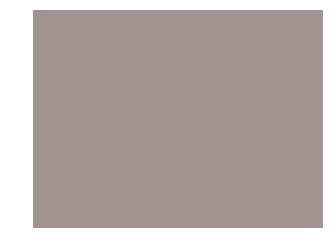

In [217]:
plt.imshow(superpixeled_image)
plt.axis('off')
plt.show()

### Affect mean pixels value to superpixels

In [66]:
mean_image = np.zeros_like(image)
labels_ = clstr_hdbscan.labels_.reshape(image.shape[0], image.shape[1])

for label in np.unique(labels_):
    region_idx = np.where(labels_ == label)
    mean_color = np.mean(image[region_idx], axis=0)
    mean_image[region_idx] = mean_color

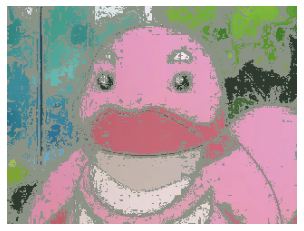

In [67]:
plt.imshow(mean_image)
plt.axis('off')
plt.show()

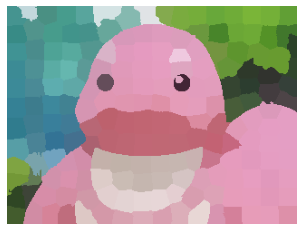

In [34]:
plt.imshow(mean_image)
plt.axis('off')
plt.show()

### Take mean by block

In [107]:
from skimage.measure import block

In [146]:
B = block.view_as_blocks(smooth_img, block_shape=(16, 16, 3))
B = B.reshape(B.shape[0], B.shape[1], -1, 3)
mean_B = np.mean(B, axis=2)

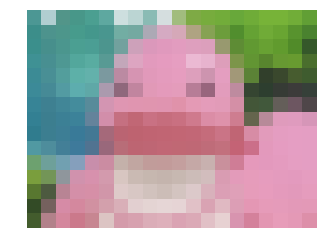

In [147]:
plt.imshow(mean_B)
plt.axis('off')
plt.show()

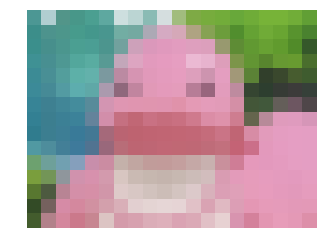

In [148]:
plt.imshow(mean_B)
plt.axis('off')
plt.show()